## 思路：
1.将文件夹中的txt文件读取出来（去重）放入集合，然后对他们进行切词，并且分为训练和测试集
2.将词根据词频从大到小排列放入列表，选取特征词
3.将训练集和测试集的词和选取的特征词进行比较，得到特征词训练和测试集
4.将得到的训练集和测试集放入nltk分类器，得到正确率

In [1]:
#coding: utf-8
import os
import jieba  #process Chinese
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter

In [2]:
#remove repeated
def make_word_set(words_file):
    words_set = set()
    with open(words_file, 'rb') as fp:
        for line in fp.readlines():
            word = line.strip().decode('utf-8')
            if len(word)>0 and word not in words_set:
                words_set.add(word)
    return words_set


In [3]:
def text_processing(folder_path, test_size=0.4):
    folder_list = os.listdir(folder_path)
    data_list = []
    class_list = []

    # search all the folder
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path, folder)
        files = os.listdir(new_folder_path)
        # read file
        j = 1
        for file in files:
#             if j > 100:  #every times we just get 100 files to avoid memory exploded
#                 break
            with open(os.path.join(new_folder_path, file), 'rb') as fp:
                raw = fp.read().decode('utf-8')
            word_cut = jieba.cut(raw, cut_all=False)  # return genertor
            word_list = list(word_cut)  # transfer generator into list

            data_list.append(word_list)  
            class_list.append(folder)  # the label is every folder name
            j += 1

    #split training set and testing set
    train_data_list, test_data_list, train_class_list, test_class_list = train_test_split(data_list, class_list, test_size=test_size)

    # make a term frequency count and sorted 
    all_words_dict = {}
    for word_list in train_data_list:
        words_dict = Counter([word for word in word_list])
        all_words_dict = dict(Counter(all_words_dict)+words_dict)
    
    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f: f[1], reverse=True)  
    all_words_list = list(zip(*all_words_tuple_list))[0]

    return data_list, class_list, all_words_list, train_data_list, test_data_list, train_class_list, test_class_list


In [4]:
def words_dict(all_words_list, deleteN, stopwords_set=set()):
    # choose feature words
    feature_words = []
    n = 1
    for t in range(deleteN, len(all_words_list), 1):
        if n > 1000:  # we just choose top 1000 featrues 
            break
        # drop stopwords in the text
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1 < len(
                all_words_list[t]) < 5:
            feature_words.append(all_words_list[t])
            n += 1
    return feature_words


text_features这个函数目的是将训练集和测试集中的文本和生成的特征词文本进行比较，如果是特征词返回1，不是返回0，生成训练特征集和测试特征集

In [5]:
# get the featute list
def text_features(data_list, train_data_list, test_data_list,  feature_words, flag='nltk'):
    def text_features(text, feature_words):
        text_words = set(text)
        ## -----------------------------------------------------------------------------------
        if flag == 'NB' or 'svm':
            ## NB or svm feature dict
            features = [1 if word in text_words else 0 for word in feature_words]
        elif flag == 'CNN':
            ## sklearn特征 list
            features = [word for word in feature_words if word in text_words]
        else:
            features = []
        ## -----------------------------------------------------------------------------------
        return features
    data = [text_features(text, feature_words) for text in data_list]
    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]
    return data, train_feature_list, test_feature_list




分类器：选用了nltk中的朴素贝叶斯分类器和sklearn的svm进行多分类

In [14]:
from sklearn.metrics import f1_score,confusion_matrix
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
def text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag='NB'):
    ## -----------------------------------------------------------------------------------
    if flag == 'NB':
        classifier = MultinomialNB().fit(train_feature_list, train_class_list)
        test_accuracy = classifier.score(test_feature_list, test_class_list)
        y_pred = classifier.predict(test_feature_list)
        y_true = test_class_list
        cm = confusion_matrix(y_true,y_pred)
    elif flag == 'svm':
        ## sklearn classifier
        model = OneVsRestClassifier(svm.SVC(kernel='rbf'))
        classifier = model.fit(train_feature_list, train_class_list)
        test_accuracy= classifier.score(test_feature_list, test_class_list)
#         test_accuracy = classifier.score(test_feature_list, test_class_list)
#         y_predict_test = classifier.predict(test_feature_list)
#         cm = confusion_matrix(test_class_list, y_predict_test)
        y_pred = classifier.predict(test_feature_list)
        y_true = test_class_list
        cm = confusion_matrix(y_true,y_pred)
    else:
        test_accuracy = []
    return cm, test_accuracy


start
[[10  0  0  0]
 [ 0 12  0  0]
 [ 0  0 11  1]
 [ 0  0  0  7]]


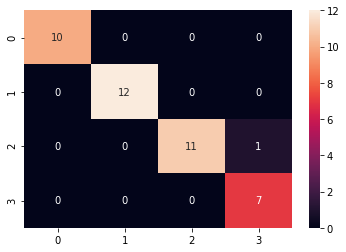

finished


In [15]:
if __name__ == '__main__':
    
    print ("start")

    folder_path = 'Database/SogouC/Sample'
    data_list, class_list, all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = text_processing(folder_path, test_size=0.2)

    # get stopwords_set
    stopwords_file = 'stopwords_cn.txt'
    stopwords_set = make_word_set(stopwords_file)

    # deleteNs means the first position we choose the feature words
    deleteN = 20
    test_accuracy_list = []
    #for deleteN in deleteNs:
    feature_words = words_dict(all_words_list, deleteN, stopwords_set)
    data, train_feature_list, test_feature_list = text_features(data_list, train_data_list, test_data_list, feature_words,flag='svm')
    cm, test_accuracy = text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list,flag='svm')
#     test_accuracy_list.append(test_accuracy)
#     best_accuracy = sorted(test_accuracy_list)[-1]
    
#     print (best_accuracy)
    print(cm)
    sns.heatmap(cm,annot=True,fmt="d")
    plt.show()
#     # 结果评价
#     plt.figure()
#     plt.plot(deleteNs, test_accuracy_list)
#     plt.title('Relationship of deleteNs and test_accuracy_NB')
#     plt.xlabel('deleteNs')
#     plt.ylabel('test_accuracy')
#     plt.show()
#     plt.savefig('result_NB.png')

    print ("finished")

start
[[13  0  0  0]
 [ 0  8  0  0]
 [ 0  0 10  0]
 [ 1  0  0  9]]


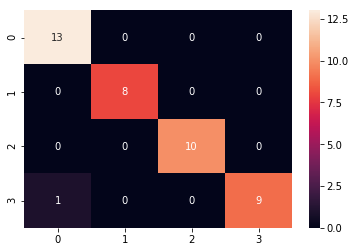

finished


In [10]:
if __name__ == '__main__':
    
    print ("start")

    folder_path = 'Database/SogouC/Sample'
    data_list, class_list, all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = text_processing(folder_path, test_size=0.2)

    # get stopwords_set
    stopwords_file = 'stopwords_cn.txt'
    stopwords_set = make_word_set(stopwords_file)

    # deleteNs means the first position we choose the feature words
    deleteN = 20
    test_accuracy_list = []
    #for deleteN in deleteNs:
    feature_words = words_dict(all_words_list, deleteN, stopwords_set)
    data, train_feature_list, test_feature_list = text_features(data_list, train_data_list, test_data_list, feature_words,flag='NB')
    cm, test_accuracy = text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list,flag='NB')
#     test_accuracy_list.append(test_accuracy)
#     best_accuracy = sorted(test_accuracy_list)[-1]
    
#     print (best_accuracy)
    print(cm)
    sns.heatmap(cm,annot=True,fmt="d")
    plt.show()
#     # 结果评价
#     plt.figure()
#     plt.plot(deleteNs, test_accuracy_list)
#     plt.title('Relationship of deleteNs and test_accuracy_NB')
#     plt.xlabel('deleteNs')
#     plt.ylabel('test_accuracy')
#     plt.show()
#     plt.savefig('result_NB.png')

    print ("finished")